### Problem Description

CiFAR 10 is a photo repository used for training and testing convolutional neural networks. It contains photos of various objects that can be categorized into 10 classes. In this notebook we will build a CNN and test its performance on this dataset. 

### Importing the Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randrange

In [2]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train.shape

Using TensorFlow backend.


(50000, 32, 32, 3)

### Visualizing Data

Before doing any further analysis, we will visualize some of the photos from the dataset. 

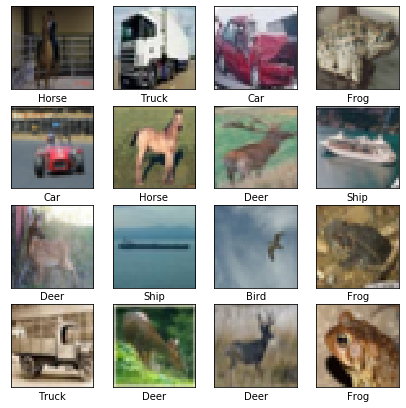

In [3]:
class_labels = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog',
               'Frog', 'Horse', 'Ship', 'Truck']


plt.figure(figsize=(7,7))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    k = randrange(5000)
    plt.imshow(X_train[k], cmap=plt.cm.binary)
    plt.xlabel(class_labels[y_train[k][0]])
plt.show()


### Preparing the Data

We scale the feature values and encode the labels.

In [4]:
#we divide with 255, since each pixel has values between 0 and 255
X_train = X_train/255
X_test = X_test/255

In [5]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

### Building the CNN

Now we build our CNN. It consists of several 3x3 convolutional layers together with max-pooling, which are then followed by several fully connected layer. 

In [6]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.optimizers import rmsprop

In [8]:
cnn = Sequential()
cnn.add(Conv2D(filters = 64, kernel_size = (3,3),
              activation = 'relu', input_shape = (32,32,3)))
cnn.add(Conv2D(filters = 64, kernel_size = (3,3),
              activation = 'relu'))
cnn.add(MaxPooling2D(2,2))
cnn.add(Dropout(0.4))


cnn.add(Conv2D(filters = 128, kernel_size = (3,3),
              activation = 'relu', input_shape = (32,32,3)))
cnn.add(Conv2D(filters = 128, kernel_size = (3,3),
              activation = 'relu'))
cnn.add(MaxPooling2D(2,2))
cnn.add(Dropout(0.4))

cnn.add(Flatten())

cnn.add(Dense(units = 1024, activation = 'relu'))
cnn.add(Dense(units = 1024, activation = 'relu'))
cnn.add(Dense(units = 10, activation = 'softmax'))

In [9]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 128)        

In [10]:
cnn.compile(loss = 'binary_crossentropy', optimizer = rmsprop(lr = 0.001),
           metrics = ['accuracy'])

In [12]:
cnn.fit(X_train, y_train, batch_size = 32, epochs = 5, shuffle = True)

Epoch 1/5
50000/50000 [==============================] - 380s 8ms/step - loss: 0.2457 - accuracy: 0.9092
Epoch 2/5
50000/50000 [==============================] - 382s 8ms/step - loss: 0.1945 - accuracy: 0.9255
Epoch 3/5
50000/50000 [==============================] - 375s 8ms/step - loss: 0.1812 - accuracy: 0.9316
Epoch 4/5
50000/50000 [==============================] - 391s 8ms/step - loss: 0.1734 - accuracy: 0.9349
Epoch 5/5
50000/50000 [==============================] - 379s 8ms/step - loss: 0.1702 - accuracy: 0.9365


### Accuracy Analysis

We obtained a good accuracy on the training set, but now we'll see how our model performs on a test set. We will also see for which classes it performs the best and the worst by making the confusion matrix. 

In [13]:
acc = cnn.evaluate(X_test,y_test)[1]
print(f'Accuracy on the test set: {round(acc*100,2)}%')

10000/10000 [==============================] - 16s 2ms/step
Accuracy on the test set: 93.61%


Our model performs on the test set as well as on the trainig set, which is a good thing. Let's now draw the confusion matrix.

In [14]:
from sklearn.metrics import confusion_matrix

y_pred = cnn.predict_classes(X_test)
y_test_class = y_test.argmax(1)

cm = confusion_matrix(y_test_class, y_pred)

In [15]:
import itertools

# Function to plot a confusion matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):

    # Plot the confusion matrix as an image
    plt.figure(figsize = (14, 14))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 22)
    
    # Tick marks show the labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Add the numbers to the plot
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center", size = 18,
                 color="white" if cm[i, j] > thresh else "black")

    # Formatting
    plt.tight_layout()
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.ylabel('True label', size = 18)
    plt.xlabel('\n Predicted label', size = 18)

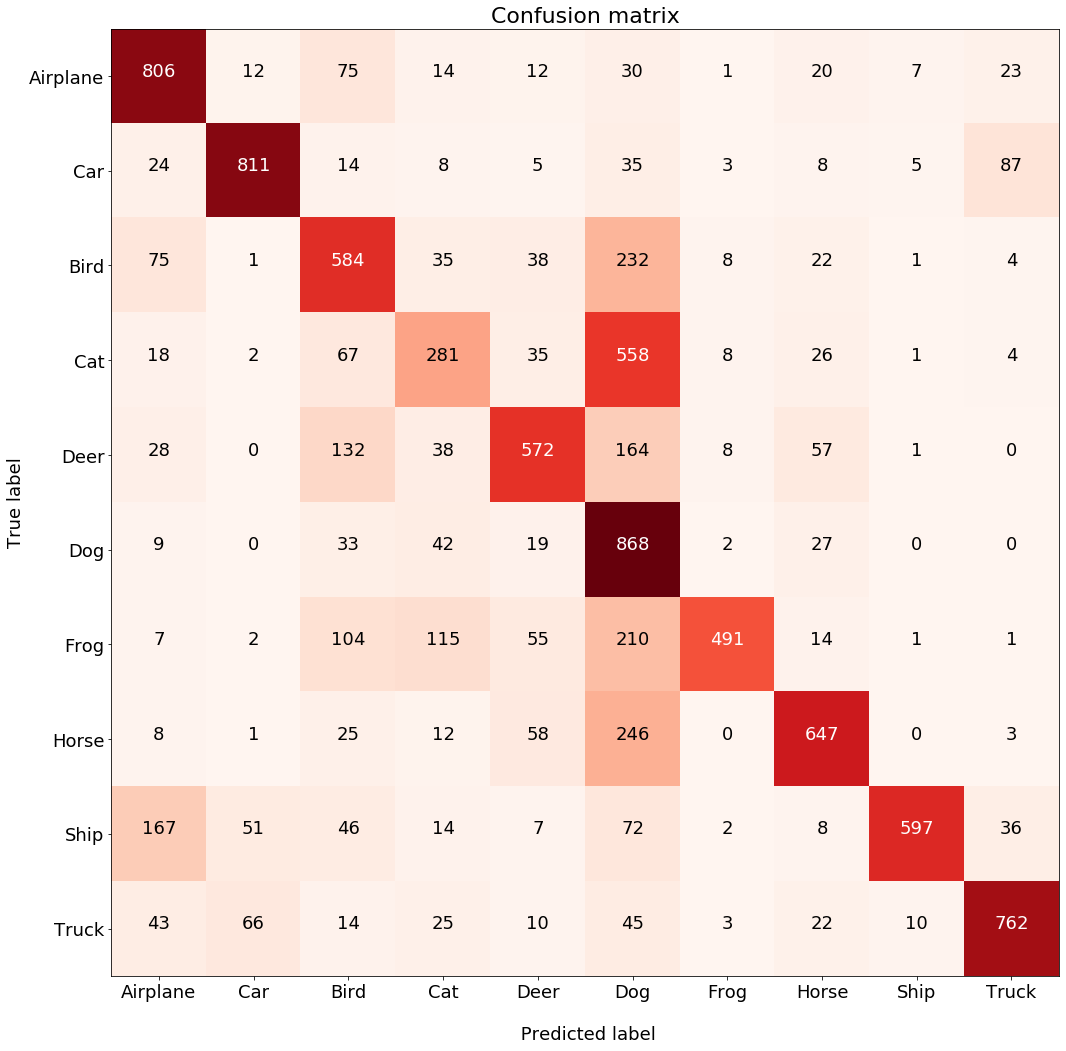

In [16]:
plot_confusion_matrix(cm, class_labels)

We see that our model have biggest problem with cats. It tends to assign cat class to other animal classes as well, most oftenly mistaking cats for dogs. When it comes to non-animal classes, most oftenly it confuses ships for airplanes. 

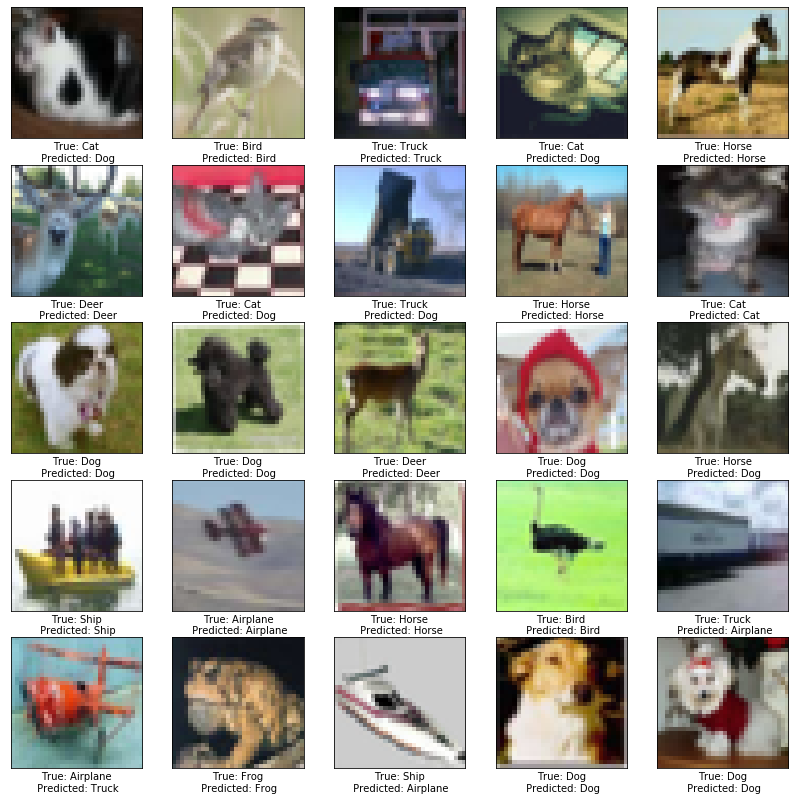

In [22]:
#X_test_sq = np.squeeze(X_test)
plt.figure(figsize=(14,14))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    k = randrange(10000)
    plt.imshow(X_test[k], cmap=plt.cm.binary)
    plt.xlabel('True: ' + class_labels[y_test_class[k]] +
        '\n Predicted: ' + class_labels[y_pred[k]])
plt.show()

### Data Augmentation

We'll now build a model using an augmented dataset, making some basic transformations. 

In [24]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
                            rotation_range = 90,
                            width_shift_range = 0.1,
                            horizontal_flip = True,
                            vertical_flip = True
                             )

datagen.fit(X_train)

In [25]:
cnn.fit_generator(datagen.flow(X_train, y_train, batch_size = 32), epochs = 5)

Epoch 1/5
1563/1563 [==============================] - 380s 243ms/step - loss: 0.2639 - accuracy: 0.9036
Epoch 2/5
1563/1563 [==============================] - 458s 293ms/step - loss: 0.2523 - accuracy: 0.9059
Epoch 3/5
1563/1563 [==============================] - 466s 298ms/step - loss: 0.2466 - accuracy: 0.9074
Epoch 4/5
1563/1563 [==============================] - 390s 249ms/step - loss: 0.2424 - accuracy: 0.9090
Epoch 5/5
1563/1563 [==============================] - 465s 298ms/step - loss: 0.2389 - accuracy: 0.9102


The model performs even worse in this case. But maybe a wiser choice of deformation parameters could bring a better performance. 

### Conclusions

We built quite simple and fast CNN model for image recognition which was able to categorize various animals and means of transport with a good accuracy, in only five epochs of training. Trainig the model for a longer time would most possibly produce even better results.